In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import arviz as az

In [2]:
az.style.use('arviz-white')

# Metropolis sampling for the concussions data

Let $Y_i$ be the number of concussions (aggregated over all teams and games) in season i (1=2012,…,4=2015). We model these counts as:

$$Y_i\sim\mbox{Poisson}(N\lambda_i) \mbox{  where  } \lambda_i=\exp(\beta_1+i\beta_2)$$

where $N$ is the number of games played per year and $\lambda_i$ is the rate in year $i$. To complete the Bayesian model, we specify uninformative priors $\beta_1,\beta_2\sim\mbox{Normal}(0,\tau^2)$.


The log of the mean concussion rate is linear in time with $\beta_2$
determining the slope. The objective is to determine if the concussion rate is increasing, i.e., $\beta_2>0$.

## Initialize

In [3]:
Y =  np.array([171, 152, 123, 199])
t =  np.arange(4)
n =  4
N =  256

## Compute the posterior on a grid for reference

In [4]:
# Create an empty matrix for the MCMC samples

S = 25000
samples = np.zeros((S, 2))
fitted = np.zeros((S, 4))

# Initial values

beta = np.array([np.log(np.mean(Y/N)), 0])

# priors: beta[j] ~ N(0,tau^2)

tau = 10
sd = (1 / tau)**0.5

# candidate standard deviations

can_sd = [0.1, 0.1]

##  Define the log posterior as a function

In [5]:
def log_post(Y, N, t, beta, sd):
    mn = N * np.exp(beta[0] + beta[1] * t)
    like = stats.poisson(mn).logpmf(Y).sum()
    prior = stats.norm(0, sd).logpdf(beta).sum()
    post = like + prior
    return post

## Metropolis sampling

In [6]:
for s in range(S):
    for j in range(2):
        can = np.copy(beta)
        can[j] = stats.norm(beta[j], can_sd[j]).rvs(1)
        logR = log_post(Y, N, t, can, sd) - log_post(Y, N, t, beta, sd)
        if np.log(stats.uniform(0, 1).rvs(1)) < logR:
            beta = can
    samples[s:, ] = beta
    fitted[s:, ] = N * np.exp(beta[0] + beta[1]*t)

In [7]:
sampler_dict = {'β1': samples[:,0], 'β2': samples[:,1]}

## Compute the acceptance rates and plot the samples

In [8]:
# Acceptance rates 
np.mean(np.diff(samples, axis=0) > 0, 0)

array([0.21168847, 0.125085  ])

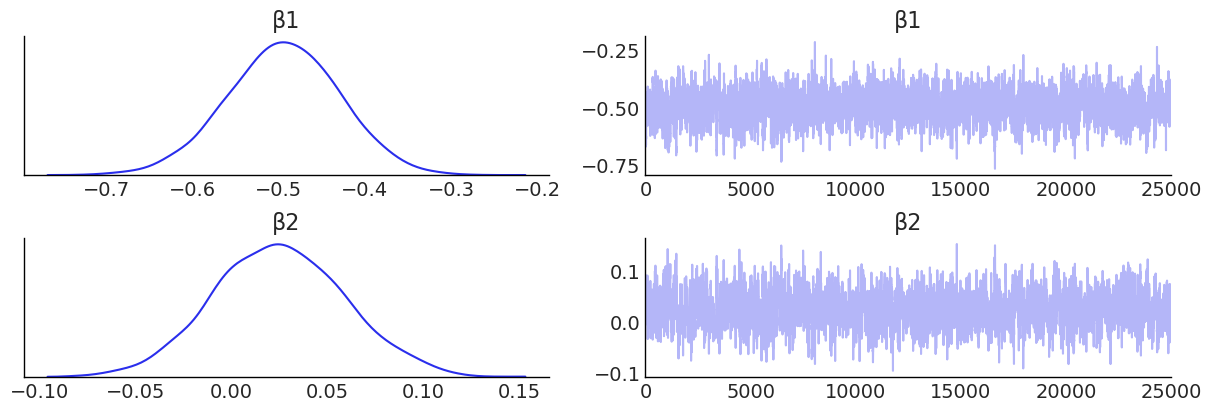

In [9]:
az.plot_trace(sampler_dict);

## Summarize the fitted values for each year

The boxplots are the posterior distribution of the $N\lambda_i=N\exp(\beta_1+i\beta_2)$, and the points are the observed counts. The linear trend doesn't fit particularly well.

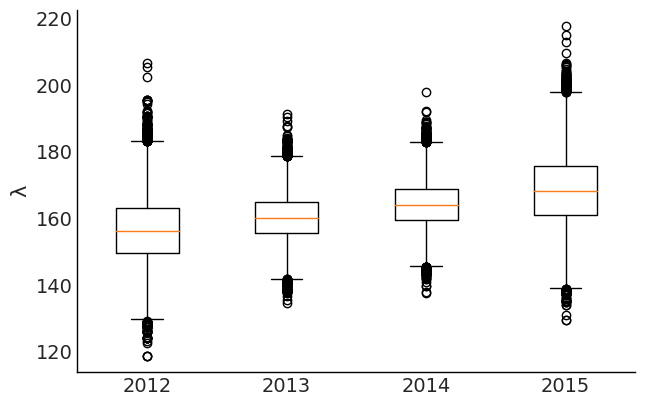

In [10]:
plt.boxplot(fitted[:,:4], labels=[y for y in range(2012, 2016)])
plt.ylabel('λ');

In [11]:
# Posterior probability that the slope is positive
np.mean(samples[:,1] > 0)

0.76392

There is some evidence that the rate is increasing, but it seems to be driven only by the last year.